In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

First lets load our data

In [2]:
data = pd.read_csv("./data/iris.csv")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We will represent species (or classes) as integers instead of their names. To do this we will use sci-kit's LabelEncoder

In [3]:
label_enc = LabelEncoder()
data["species"] = label_enc.fit_transform(data["species"])

In [4]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Our decision tree uses categorical input. However we have ordinal data. To turn our ordinal data to categorical we will use sci-kit's Discretizer. We will uniformly divide our data into 3 bins. You can try different paramters such as changing the number of bins or using other methods of forming the bins such as k-means. 

Lets check how many classes we have and number of samples belonging to each class. As you can see we have a uniformly distributed data. Each class has 50 samples

In [5]:
print(np.unique(data["species"],return_counts=True))

(array([0, 1, 2]), array([50, 50, 50]))


There are different ways to build a decision tree such as using information gain or gini index

In [6]:
# y_data = [left,right] treshold<, <treshold
def gini_c(data):
    _ , counts = np.unique(data,return_counts=True)

    gini = (counts/len(data))**2

    gini = 1 - gini.sum()
    return gini

def compute_gini(y_data):
    
    weighted_gini = []
    n = 0
    for i in y_data:
        #what if i is empty????
        #count how many different
        gini = gini_c(i)
        
        weighted_gini.append(gini * len(i))
        
        n+=len(i)
    weighted_gini = np.array(weighted_gini)/n
    return weighted_gini.sum()

In [7]:
#test compute_gini

In [8]:
y_data = [np.array([0]),np.array([2,2,1,0])]
print(compute_gini(y_data))

0.5


In [9]:
y_data = [np.array([1,2,1,1,0]),np.array([1,0,0])]
compute_gini(y_data)

0.5166666666666666

In [10]:
y_data = [np.array([1,0,0,0,0]),np.array([1,2,2,2,0])]
compute_gini(y_data)

0.43999999999999995

In [11]:
gini_c(np.array([1,1,1,1]))

0.0

In [12]:
def gini_select(X,Y):
    # X ve Y sort edilmeli
    X2 = X.copy()
    X2 = X2.sort_values() # we create a copty of X just for finding the thresholds (because we don't want to sort the original data)
 
    thresholds = X2.rolling(2).mean()[1:] # moving average, since first value is NAN we remove it

    unique_vals , _ = np.unique(thresholds,return_counts=True) # unique thresholds
    
    gini_list = []

    for tresh in unique_vals:
        left_d = np.where(X<tresh)[0] # actually we can iterate over thre X once and use if<thresh,else to divide data
        right_d = np.where(X>=tresh)[0] # and not use np.where twice but numpy is faster than regular for loop

        gini = compute_gini([Y.iloc[left_d],Y.iloc[right_d]]) #select elements of Y (labels) and compute gini
        gini_list.append(gini)
        
        """
        Burada gini her adımda öncekilerle karşılaştırılarak minimum değerbulunabilir
        Eğer left ve right datanın kopyası tutulup her minimum değiştiğinde değiştirilirse 
        sadece tek kopya tutup tekrar bunları hesaplamaya gerek kalmaz
        
        
        """
        
        
    
    arg_min = np.argmin(gini_list) #select lowest gini val
    thres_val = unique_vals[arg_min] # select threshold for lowest gini
    return thres_val,gini_list[arg_min]

In [13]:
r = [47,9,36]
data2 = data.iloc[r,:]
print(data2["species"])
print(gini_c(data2["species"]))
print(gini_select(data2.iloc[:,3],data2.iloc[:,-1]))

47    0
9     0
36    0
Name: species, dtype: int64
0.0
(0.15000000000000002, 0.0)


In [14]:
data2.iloc[:,0]

47    4.6
9     4.9
36    5.5
Name: sepal_length, dtype: float64

In [15]:
np.random.seed(0)

#r = np.random.randint(0,150,5)

r = np.random.randint(0,50,5)

X = data["sepal_length"].iloc[r]
Y = data["species"].iloc[r]

t,g = gini_select(X,Y)


In [16]:
X

44    5.1
47    4.6
0     5.1
3     4.6
3     4.6
Name: sepal_length, dtype: float64

In [17]:
t

4.6

In [18]:
g

0.0

In [19]:
def find_split_feature(data):
    feature_select_list = []
    for feature_name in data.columns[:-1]:
        split_val,gini = gini_select(data[feature_name],data.iloc[:,-1])
        feature_select_list.append([feature_name,gini,split_val])
    feature_select_list = np.array(feature_select_list)
    arg_min = np.argmin(feature_select_list[:,1])
    
    feature_name = feature_select_list[arg_min,0]
    threshold = feature_select_list[arg_min,2]
    gini_val = feature_select_list[arg_min,1]
    
    
    
    # eğer daha ayrılmıyorsa None gibi birşey return etmeli
    
    #because we can not have np arrays with different typed
    #elements numpy changed everything into string (due to feature name being a string) now we have to revert it
    return feature_name,float(threshold),float(gini_val)  
    
    
    

In [21]:
find_split_feature(data)

('petal_length', 2.45, 0.3333333333333333)

In [22]:
# find_split çalışıyor

In [23]:
#bir yerde datayı bölmemiz lazım ki recursion kullanabilelim

In [24]:
gini_select(data.iloc[0,:-1],data.iloc[:,-1])

(0.7999999999999999, 0.0)

In [25]:
r = [117,67,103,87,70,88]
data2 = data.iloc[r,:]

In [26]:
find_split_feature(data2)

('petal_length', 5.199999999999999, 0.0)

In [27]:
a  = [[1,2,3],[3,1,2],[0,5,6]]

In [52]:
class Node():
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.label = None

    def __repr__(self):
        if self.feature == None:
            return "Leaf->Label: {}".format(self.label)
        else:
            return "Node->Feature: {} Threshold: {}".format(self.feature,self.threshold)

In [135]:
class TreeNode():
    def __init__(self):
        self.root = Node()

    def build_tree(self,node,data):

    
        gini = gini_c(data.iloc[:,-1])
        if gini!=0:
            feature_name,threshold, gini = find_split_feature(data)

            node.feature = feature_name
            node.threshold = threshold

            d = data[feature_name]

            left_d = data.iloc[np.where(d<threshold)[0],:] 
            right_d = data.iloc[np.where(d>=threshold)[0],:]
            node.left = Node()

            self.build_tree(node.left,left_d)
            node.right = Node()

            self.build_tree(node.right,right_d)
        else:
            unique_vals , _ = np.unique(data.iloc[:,-1],return_counts=True)
            node.label = unique_vals[0]
            
    def predict(self,node,data):
        if node.label==None:
            d = data[node.feature]

            if d<node.threshold:

                return self.predict(node.left,data)
            else:

                return self.predict(node.right,data)
        else:

            return node.label
        
    def predict_dataset(self,data):
        output = []
        for i in range(len(data)):
            output.append(self.predict(self.root,data.iloc[i,:-1]))
        return np.array(output)
            

In [136]:
a = TreeNode()
a.build_tree(a.root,data)

In [141]:
a.predict_dataset(data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [65]:
data.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [78]:
tree_node.right.right.

Node->Feature: petal_length Threshold: 4.85

In [66]:
tree_node.threshold

2.45

In [106]:
a.right.right.right

Leaf->Label: 2

In [62]:
plt.rcParams["figure.figsize"] = (15,5) # make figures larger

In [ ]:
a = TreeNode()
a.build_tree(a.root,data)

In [142]:
from sklearn.model_selection import train_test_split

In [167]:
r = np.random.randint(0,150,50)

In [168]:
data2 = data.iloc[r,:]

In [169]:
a = TreeNode()
a.build_tree(a.root,data2)

In [170]:
out_e = a.predict_dataset(data2)

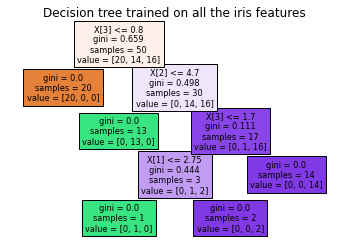

In [171]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
plt.figure()
clf = DecisionTreeClassifier().fit(data2.iloc[:,:-1], data2.iloc[:,-1])
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [172]:
c = clf.predict(data2.iloc[:,:-1])

In [173]:
(c == out_e).sum()

50